In [24]:
from pathlib import Path
import numpy as np
import pickle, json
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Your project root on Windows
ROOT   = Path.home() / "ML_projs" / "image_captioning"
DATA   = ROOT / "data"
PROC   = DATA / "processed"
IMAGES = DATA / "images" / "flickr8k"
MODELS = ROOT / "models"

print("ROOT:", ROOT)

ROOT: C:\Users\mkalam\ML_projs\image_captioning


In [25]:
with open(PROC / "tokenizer.pkl", "rb") as f:
    tok = pickle.load(f)

itos, stoi, max_len = tok["itos"], tok["stoi"], tok["max_len"]
vocab_size = len(itos)

def idx_to_word(idx): 
    return itos[idx] if 0 <= idx < len(itos) else "<unk>"

def word_to_idx(word):
    return stoi.get(word, stoi.get("<unk>", 1))

print("Vocab size:", vocab_size, "| max_len:", max_len)


Vocab size: 3063 | max_len: 20


In [26]:
model_path_keras = MODELS / "caption_decoder.keras"
model_path_h5    = MODELS / "caption_decoder.h5"

if model_path_keras.exists():
    decoder_model = load_model(model_path_keras)
    print("Loaded:", model_path_keras.name)
else:
    decoder_model = load_model(model_path_h5)
    print("Loaded:", model_path_h5.name)

# What feature dimension does the decoder expect?
expected_feat_dim = int(decoder_model.inputs[0].shape[1])
print("Decoder expects feature dim:", expected_feat_dim)


Loaded: caption_decoder.keras
Decoder expects feature dim: 1280


In [27]:
IMG_SIZE = 224
encoder_model = None
preprocess_fn = None

# Try EfficientNetB0 first (1280-dim)
try:
    from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
    tmp = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg",
                         input_shape=(IMG_SIZE, IMG_SIZE, 3))
    if tmp.output_shape[-1] == expected_feat_dim:
        encoder_model = tmp
        preprocess_fn = preprocess_input
        print("Using EfficientNetB0 encoder.")
    else:
        raise ValueError("EfficientNetB0 feature dim mismatch.")
except Exception as e:
    print("EfficientNetB0 not used:", e)

# Fallback to ResNet50 (2048-dim)
if encoder_model is None:
    from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
    tmp = ResNet50(include_top=False, weights="imagenet", pooling="avg",
                   input_shape=(IMG_SIZE, IMG_SIZE, 3))
    if tmp.output_shape[-1] != expected_feat_dim:
        raise RuntimeError(
            f"No matching encoder found. Decoder expects {expected_feat_dim}, "
            f"ResNet50 outputs {tmp.output_shape[-1]}. Double-check which backbone you used."
        )
    encoder_model = tmp
    preprocess_fn = preprocess_input
    print("Using ResNet50 encoder.")

encoder_model.trainable = False

Using EfficientNetB0 encoder.


In [28]:
def extract_feature_from_image(img_path: str):
    img_bytes = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    img = preprocess_fn(img)                        # IMPORTANT: same preprocessing as training
    feat = encoder_model(tf.expand_dims(img, 0), training=False)  # [1, feat_dim]
    return feat.numpy()[0]                          # [feat_dim]


In [35]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def greedy_caption_from_feature(feat_vec):
    seq = ["startseq"]
    for t in range(max_len - 1):
        in_seq_ids = [word_to_idx(w) for w in seq]
        in_seq_ids = pad_sequences([in_seq_ids], maxlen=max_len, padding='post')[0]
        preds = decoder_model.predict([np.expand_dims(feat_vec, 0), np.expand_dims(in_seq_ids, 0)], verbose=0)
        next_id = int(np.argmax(preds[0, t, :]))  # distribution at current time step
        next_word = idx_to_word(next_id)
        if next_word == "endseq":
            break
        seq.append(next_word)
    # remove special tokens
    words = [w for w in seq[1:] if w not in ("startseq", "endseq", "<pad>")]
    return " ".join(words)


Image: 3250695024_93e8ab7305.jpg
Caption: a woman in a blue shirt and woman in a blue dress


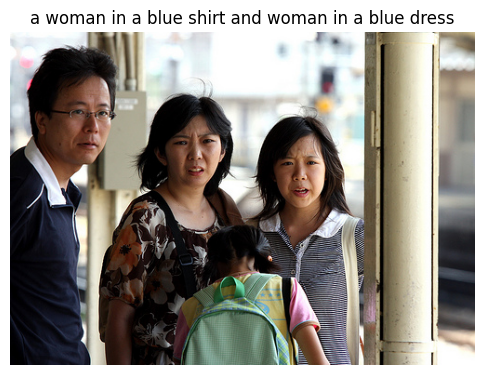

In [36]:
# Load saved test features (you can also use train/val)
test_npz  = np.load(PROC / "features_b0_test.npz")
feat_map_test = {fn: feat for fn, feat in zip(test_npz["filenames"], test_npz["features"])}

sample_img = list(feat_map_test.keys())[45]
cap = greedy_caption_from_feature(feat_map_test[sample_img])
print("Image:", sample_img)
print("Caption:", cap)

# Show the image with its caption
img_path = IMAGES / sample_img
img = Image.open(img_path)
plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis("off"); plt.title(cap); plt.show()


Caption: a woman in a blue and white shirt is jogging on a road


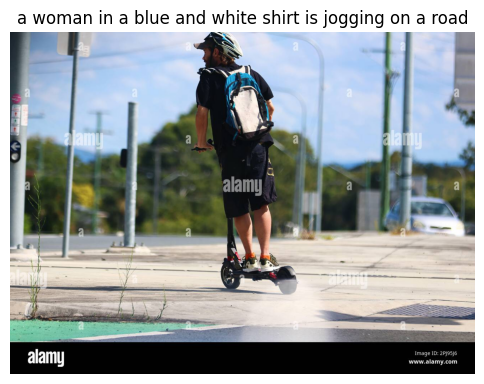

In [37]:
custom_img = r"C:\Users\mkalam\ML_projs\image_captioning\data\images\something.jpg"
feat = extract_feature_from_image(custom_img)
cap  = greedy_caption_from_feature(feat)
print("Caption:", cap)

img = Image.open(custom_img)
plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis("off"); plt.title(cap); plt.show()
